In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,8]

In [2]:
# [Optional]
# This package allows to visualize the progress during a loop and estimate the remaining time of execution
# If you don't want to install it, please search for pbar = tqdm(total = t_max), pbar.update(1) and pbar.close() 
#code lines and delete them

from tqdm import tqdm_notebook as tqdm

# <font color='color'> Introduction </font>

During this Practical work, we are going to first generate data following a GMM model, and then we are going to implement an EM algorithm in order to infer the GMM model parameters. First, let's introduce a GMM model :

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians : 

\begin{align}
X_i &\sim GMM(\mu_{1:K}, \Sigma_{1:K}, \pi_{1:K}) \\
\end{align}
With : 

* $K$ : number of gaussian

* $\mu_{k}$ : mean of the kth gaussian

* $\Sigma_k$ : cov matrix of the kth gaussian

* $\pi_k$ : weight of the kth gaussian, $\sum_{k=1}^{K} \pi_k = 1$


# <font color='color'> Question 1 : Numerically Stable computation of $\gamma_i$ </font>


In Gaussian Mixture Models, we often need to evaluate quantities that are defined as follows:

\begin{align}
\gamma_i(x) &= \frac{\pi_i\mathcal{N}(x; \mu_i,\,\Sigma_{i})\,}{\sum_{j=1}^K \pi_j\mathcal{N}(x; \mu_j,\,\Sigma_{j})\,}
\end{align}

A direct computation of these quantities might be problematic in practice since all the terms ($\pi_i\mathcal{N}(x; \mu_i,\,\Sigma_{i})\,$) might be very small, and we might end up with 0/0. So, we need to find a numerically stable way to calculate $\gamma_i(x)$. We can write $log(\gamma_i(x))$ as : 

\begin{align}
log(\gamma_i(x)) &= log(\pi_i\mathcal{N}(x; \mu_i,\,\Sigma_{i})\,) - log(\sum_{j=1}^K \pi_j\mathcal{N}(x; \mu_j,\,\Sigma_{j})\,)\\
                 &= log(l_i) - log(\sum_{j=1}^K exp(l_j))
\end{align}

### <font color='color'> 1.1 : Numerically Stable computation of $log(l_i)$ </font>


In the expression of $log(l_i)$,
\begin{align}
log(l_i) &= log(\pi_i) - \frac{N}{2}log(2\pi) - \frac{1}{2} log(Det(\Sigma_i)) - \frac{1}{2}(x - \mu_i)^T\Sigma_i^{-1}(x - \mu_i) \quad avec \quad N = dim(x)
\end{align}

We need to find a numercially stable way to compute $log(Det(\Sigma_i))$. To do so, we can use **Cholesky factorization Theorem.** In fact, we have $\Sigma_i$ is a Hermitian positive-definite matrix by definition. following Cholesky factorization Theorem, we can decompose $\Sigma_i = LL^T$, with L a lower triangular matrix with real and positive diagonal entries. So, we can write $log(Det(\Sigma_i))$ as following : 

\begin{align}
log(Det(\Sigma_i)) &= log(Det(LL^T))\\
                   &= log(Det(L)Det(L^T))\\
                   &= 2log(Det(L))\\
                   &= 2\sum log(L_{jj})
\end{align}

All we have to do is to find the values of $L_{jj}$. By a sample system, we obtain : 

\begin{align}
(\Sigma_i)_{kj} &= (LL^T)_{kj}\\
                   &= \sum_{h=1}^{n}{l_{kh}l_{jh}} \\
                   &= \sum_{h=1}^{min (k,j)}{l_{kh}l_{jh}} \quad because \quad l_{pq}=0 \quad if \quad 1≤p<q≤n\\
                   &= \sum_{h=1}^{k}{l_{kh}l_{jh}} \quad \quad 1≤k≤j≤n\\
\end{align}

We deduce that : 

* $(\Sigma_i)_{11} = l_{11}l_{11} \Longrightarrow$ $l_{11} = \sqrt{(\Sigma_i)_{11}}$

* $(\Sigma_i)_{1j} = l_{11}l_{j1} \Longrightarrow$ $l_{j1} = \frac{(\Sigma_i)_{1j}}{l_{11}}$

* $(\Sigma_i)_{jj} =  l_{j1}l_{j1} + .. + l_{jj}l_{jj} \Longrightarrow$ $l_{jj} = \sqrt{(\Sigma_i)_{jj} - \sum_{h=1}^{j-1}{ l_{jh}^2}}$

* $(\Sigma_i)_{jk} =  l_{j1}l_{k1} + .. + l_{jj}l_{kj} \Longrightarrow$ $l_{jk} = \frac{(\Sigma_i)_{jk} - \sum_{h=1}^{j-1}{l_{jh}l_{kh}} }{l_{jj}}$


<font color='color'> Remarque: </font> The calculation of $log(Det(\Sigma_i))$ can be done using la commande numpy.linalg.slogdet(matrix)

### <font color='color'> 1.2 : Numerically Stable computation of $log(\sum exp(l_i))$ </font>


To insure the stability of the computation, one method consists at introducing $l_{max} = max_i {l_i}$ in the expression of $L$ as following:

\begin{align}
log(\sum exp(l_i)) &= log(\sum exp(l_i - l_{max} + l_{max})) \\
           &= log( exp(l_{max})  \sum exp(l_i - l_{max})) \\
           &= l_{max} + log(\sum exp(l_i - l_{max}))
\end{align}

In [6]:
def calculate_log_sum_exp(v):
    """ 
    This function calculates the log of sum(exp(v)) on a numerically stable way
    input :
    v : vector N*1, dtype = ndarray(N*1)    
    Output : 
    log(sum(exp(v))) : dtype = array
    """

    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - np.repeat(v_max, len(v)))))

In [7]:
def calculate_gamma(x, mu, sigma, pi, K):
    """ 
    This function takes an observation, a GMM parameters 
    and returns the corresponding gamma necessary for 
    EM algorithm for each component of the GMM
    
    input :
    x : data input d*1, dtype = ndarray(d*1)
    mu : vector of gaussians means, dtype = ndarray(K,d)
    sigma : vector of gaussians covariance, dtype = ndarray(d,d,K)
    pi : vector of gaussians weights, dtype = ndarray(K,1)
    K : number of gaussians, dtype = int
    
    Output : 
    log_sum_exp : vector as described below, dtype = ndarray(K,1)
    gamma : values of gamma_k, dtype = ndarray(K,1)
    """

    l = []
    N = len(x)
    for k in range(K):
        (sign, logdet) = np.linalg.slogdet(sigma[k])
        inter = np.dot((x - mu[k]), np.linalg.inv(sigma[k]))
        l.append(np.log(pi[k]) - N/2 * np.log(2*np.pi) - 0.5*logdet - 0.5*np.dot(inter, (x - mu[k]).T))
    
    log_sum_exp = calculate_log_sum_exp(l)
    gamma = np.exp(l - log_sum_exp)
    return gamma, log_sum_exp

### <font color='color'> Test </font>


Here, we test our function with an example (which by the way isn't problematic in direct calculation). We compare the result with the python direct commands to calculate gamma. 

In [33]:
K = 3
N = 1000
pi = [0.3, 0.2, 0.5]
mu1 = [0,0]
mu2 = [1,2]
mu3 = [2,0]
mu = [ mu1, mu2, mu3 ]

sigma1 = [[1, -0.25], [-0.25, 0.5]]
sigma2 = [[0.5, 0.25], [0.25, 0.5]]
sigma3 = [[0.5, -0.25], [-0.25, 1]]
sigma = [sigma1, sigma2, sigma3]

x = np.array([0,1])

#### <font color='color'> 1. Calculation using the functions below </font>


In [34]:
gamma, log_sum_exp = calculate_gamma(x, mu, sigma, pi, K)

In [35]:
gamma

array([0.51614127, 0.43445316, 0.04940557])

#### <font color='color'> 2. Using scipy multivariate_normal function </font>


In [13]:
l = []
N = len(x)
for k in range(K):
     l.append(pi[k] * multivariate_normal.pdf(x, mu[k], sigma[k]))
gamma = l / np.sum(l)  

In [14]:
gamma

array([2.91073236e-04, 9.25624506e-01, 7.40844212e-02])

We can se here that we have the same value of gamma using the same input.

# <font color='color'> Question 2 : EM algorithm </font>


The **EM Algorithm** is composed by 2 main steps : 

1. E-step : Evaluate the expectation : $\mathrm{L}_{t}(\theta) = \mathrm{E}[\log p(X, Z | \theta)]_{p(Z|X,\theta^{(t)})}$, with :
    * X : All observations. In our case X_{1:N}
    * Z: All hidden variables. In our case Z_{1:N}
    * $\theta$ : All parameters. In our case $\theta = (\mu_{1:K}, \Sigma_{1:K}, \pi_{1:K})$ 


2. M-step : Find $\theta^{(t+1)}$ that maximizes $\mathrm{L}_{t}(\theta)$


We have shown during the course session that 

\begin{align}
\mathrm{L}_{t}(\theta)  &= \sum_{n=1}^{N}\sum_{k=1}^{K}\gamma_k^{(t)}(X_n).[\log \pi_k + \log \mathcal{N}(X_n; \mu_k,\,\Sigma_{k})\,]\\
                   &= \sum_{n=1}^{N}\sum_{k=1}^{K}\gamma_k^{(t)}(X_n).[\log \pi_k - \frac{p}{2}log(2\pi) - \frac{1}{2} \log(Det(\Sigma_k)) - \frac{1}{2}(X_n - \mu_k)^T\Sigma_k^{-1}(X_n - \mu_k)]
\end{align}



<font color='color'> **Maximize  $\mathrm{L}_{t}(\theta)$ w.r.t $\mu_k$** </font>

\begin{align}
\frac{\partial \mathrm{L}_{t}(\theta)}{\partial \mu_k} &= \sum_{n=1}^{N}\gamma_k^{(t)}(X_n)\Sigma_k^{-1}(X_n - \mu_k) = 0
\end{align}

$\Longrightarrow \sum_{n=1}^{N}\gamma_k^{(t)}(X_n)(X_n - \mu_k) = 0$  
<br>
$\Longrightarrow \mu_k = \frac{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n).X_n}{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n)}$

<br>
<font color='color'> **Maximize  $\mathrm{L}_{t}(\theta)$ w.r.t $\Sigma_k$** </font>

\begin{align}
\frac{\partial \mathrm{L}_{t}(\theta)}{\partial \Sigma_k} &\propto \sum_{n=1}^{N}\gamma_k^{(t)}(X_n)[- \Sigma_k^{-1} + \Sigma_k^{-1}(X_n - \mu_k)(X_n - \mu_k)^T\Sigma_k^{-1}] = 0
\end{align}

<br>
$\Longrightarrow \sum_{n=1}^{N}\gamma_k^{(t)}(X_n)\Sigma_k^{-1} = \sum_{n=1}^{N}\gamma_k^{(t)}(X_n)\Sigma_k^{-1}(X_n - \mu_k)(X_n - \mu_k)^T\Sigma_k^{-1}$  

<br>

$\Longrightarrow \Sigma_k = \frac{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n)(X_n - \mu_k)(X_n - \mu_k)^T}{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n)}$

<br>
<font color='color'> **Maximize  $\mathrm{L}_{t}(\theta)$ w.r.t $\pi_k$, with constraint :  $\sum_{k=1}^{K}\pi_k = 1$** </font>

\begin{align}
\frac{\partial (\mathrm{L}_{t}(\theta) + \lambda (1 - \sum_{k=1}^{K}\pi_k))}{\partial \pi_k} &= \sum_{n=1}^{N}\frac{1}{\pi_k}\gamma_k^{(t)}(X_n) - \lambda = 0, \quad \sum_{k=1}^{K}\pi_k = 1
\end{align}

$\Longrightarrow \pi_k = \frac{1}{\lambda}\sum_{n=1}^{N}\gamma_k^{(t)}(X_n) $
<br>

$\Longrightarrow \sum_{k=1}^{K}\pi_k = 1 = \sum_{k=1}^{K} \frac{1}{\lambda}\sum_{n=1}^{N}\gamma_k^{(t)}(X_n) = \frac{1}{\lambda} \sum_{n=1}^{N} \sum_{k=1}^{K} \gamma_k^{(t)}(X_n)$
<br>

$\Longrightarrow \frac{1}{\lambda} \sum_{n=1}^{N} 1 = 1$ $\quad \Longrightarrow  \lambda = N$
<br>

$\Longrightarrow \pi_k = \frac{1}{N}\sum_{n=1}^{N}\gamma_k^{(t)}(X_n) $
<br>
<font color='color'> **Conclusion** </font>
<br>

* $\mu_k^{(t+1)} = \frac{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n).X_n}{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n)}$


* $\Sigma_k^{(t+1)} = \frac{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n)(X_n - \mu_k^{(t+1)})(X_n - \mu_k^{(t+1)})^T}{\sum_{n=1}^{N}\gamma_k^{(t)}(X_n)}$

* $\pi_k^{(t+1)} = \frac{1}{N}\sum_{n=1}^{N}\gamma_k^{(t)}(X_n) $

# <font color='color'> Question 3 : GMM </font>


### <font color='color'> Question 3.1 : Generative GMM </font>


In [12]:
def generate_gmm(K, N, pi, mu, sigma):
    """ 
    This function takes GMM parameters (K, pi, mu and sigma) 
    and returns N data points generated following this model
    
    input :
    mu : vector of gaussians means, dtype = ndarray(K,d)
    sigma : vector of gaussians covariance, dtype = ndarray(d,d,K)
    pi : vector of gaussians weights, dtype = ndarray(K,1)
    K : number of gaussians, dtype=int
    N : number of data points to generate, dtype=int
    
    Output : 
    x : vector of N data points, dtype = ndarray(N,d)
    """
    component = np.random.choice(np.arange(0,K), N, p=pi)
    x = []
    for i in component:
        x.append(np.random.multivariate_normal(mu[i], sigma[i]))
    return np.array(x)

In [13]:
K = 3
N = 1000
pi = [0.3, 0.2, 0.5]
mu1 = [0,0]
mu2 = [1,2]
mu3 = [2,0]
mu = [ mu1, mu2, mu3 ]
sigma1 = [[1, -0.25], [-0.25, 0.5]]
sigma2 = [[0.5, 0.25], [0.25, 0.5]]
sigma3 = [[0.5, -0.25], [-0.25, 1]]

sigma = [sigma1, sigma2, sigma3]

In [14]:
xn = generate_gmm(K, N, pi, mu, sigma)

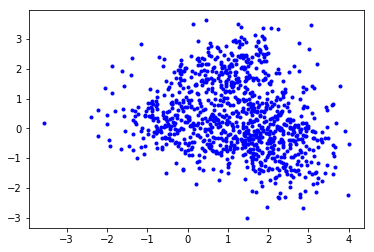

In [15]:
plt.plot(xn[:,0], xn[:,1], 'b.')
plt.show()

### <font color='color'> Question 3.2 : GMM inference </font>


In [16]:
def EM_algorithm(xn, K, pi0, mu0, sigma0, t_max):
    """ 
    This is an EM algorithm implementation
    
    input :
    xn : data points, dtype=ndarray(N,2)
    K : number of gaussians, dtype=int
    pi0 : gaussians weights initialization, dtype = ndarray(K,1)
    mu0 : gaussians means initialization, dtype = ndarray(K,d)
    sigma0 : gaussians covariance matrices initialization, dtype = ndarray(d,d,K)
    t_max : maximal number of iterations, dtype=int
        
    Output : 
    pi : vector of weights calculated in each step, dtype=list
    mu : vector of means calculated in each step, dtype=list
    sigma : vector of covariance matrices calculated in each step, dtype=list
    gamma : vector of posterior distribution calculated in each step, dtype=list
    log_likelihood : vector of log_likelihood calculated in each step, dtype=list 
    """
    t = 0
    pi = [pi0]
    mu = [np.array(mu0)]
    sigma = [sigma0]
    gamma = []
    #Update 
    norm = 1
    pbar = tqdm(total = t_max)
    log_likelihood = np.array([])
    while (norm>0.0001 and t<t_max):
        
        #E-step
        #gamma_t.shape = (1000, 3)
        gamma_t, log_sum_exp = calculate_gamma(xn[0], mu[t], sigma[t], pi[t], K)
        for i in range(1,N):
            g, l = calculate_gamma(xn[i], mu[t], sigma[t], pi[t], K)
            gamma_t = np.vstack((gamma_t, g))
            log_sum_exp = np.append(log_sum_exp, l)
        log_likelihood = np.append(log_likelihood, np.sum(log_sum_exp))
        gamma.append(gamma_t)
        
        #M_step : update 
        gamma_sum = np.sum(gamma[t], axis = 0)
        mu.append( np.dot(gamma[t].T , xn) /  gamma_sum.reshape((K,1)))
        
        sigma_t = []
        for k in range(K):
            s = 0
            for i in range(N):   
                diff = (xn[i] - mu[t+1][k]).reshape((d,1))
                s += gamma[t][i,k] * np.dot(diff, diff.T)
            
            sigma_t.append(s / gamma_sum[k])  
        
        sigma.append(sigma_t) 
        
        pi.append(1/N * gamma_sum)
        
        #stop_condition :
        norm = 0
        for k in range(K):
            norm += np.linalg.norm( sigma[t+1][k] - sigma[t][k] )
            norm += np.linalg.norm(mu[t+1][k] - mu[t][k])
        
        norm += np.linalg.norm(pi[t+1] - pi[t])
        t += 1
        pbar.update(1)
    pbar.close()
        
    return (pi, mu, sigma, gamma, log_likelihood)

#### <font color='color'> Question 3.2.a : GMM inference with random intialization </font>


In [17]:
pi0 = np.random.uniform(0,1,K)
pi0 = pi0 / sum(pi0)

d = xn.shape[1] # here d = 2
mu0 = []
for i in range(K):
    mu0.append(np.random.uniform(0,5,d))

sigma0 = []
for i in range(K):
    sigma0.append(np.random.uniform(0,5,(d,d)))

t_max = 500
(pi, mu, sigma, gamma, log_likelihood) = EM_algorithm(xn, K, pi0, mu0, sigma0, t_max)

#### We can see that with this random initialization, the algorithm converges after 268 steps

##### <font color='color'> Results evaluation </font>


In [37]:
estimated_pi = pi[-1]
estimated_mean = mu[-1]
estimated_cov = sigma[-1]

In [38]:
def sort_parameters(mu, sigma, pi):
    """
    This function sort the parameters in order to compare them with the real ones
    
    Input
    mu, sigma, pi : gmm parameters
    
    Output
    Sortet mu, sigma, pi
    """
    indices = np.argsort(mu, axis = 0)[:,0]
    mu = mu[indices]
    pi = pi[indices]
    sigma = np.array(sigma)[indices]
    return mu, sigma, pi

In [39]:
estimated_mean, estimated_cov, estimated_pi = sort_parameters(estimated_mean, estimated_cov, estimated_pi)

In [40]:
estimated_mean

array([[ 0.03853114,  0.01145904],
       [ 0.90298084,  1.95973082],
       [ 2.08468132, -0.20301314]])

In [63]:
# Real means
#mu1 = [0,0]
#mu2 = [1,2]
#mu3 = [2,0]

#### We can see that estimated means are close to the real ones

In [41]:
estimated_cov

array([[[ 0.97513212, -0.18997499],
        [-0.18997499,  0.4394181 ]],

       [[ 0.64965966,  0.17130804],
        [ 0.17130804,  0.42728297]],

       [[ 0.54962048, -0.15443243],
        [-0.15443243,  0.88095062]]])

In [65]:
# real cov
#sigma1 = [[1, -0.25], [-0.25, 0.5]]
#sigma2 = [[0.5, 0.25], [0.25, 0.5]]
#sigma3 = [[0.5, -0.25], [-0.25, 1]]

#### Same for covariance

In [42]:
estimated_pi

array([0.30932127, 0.24131809, 0.44936065])

In [67]:
#real pi 
#pi = [0.3, 0.2, 0.5]

#### Same for pi

##### <font color='color'> Evolution of gaussians contours : Step 40, 80 and 100</font>


In [65]:
def multivariate(mu, sigma, pi, indice, x, y):
    """
    This function calculates the gaussian contours
    
    Input
    mu, sigma, pi : gaussian parameters
    
    Output
    gaussian contours
    pos : parameter of the gaussian contours
    """
    m, s, p = sort_parameters(mu, sigma, pi)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    return  multivariate_normal(m[indice], s[indice]), pos

Text(0.5,1,'3rd estimated gaussian, step 100')

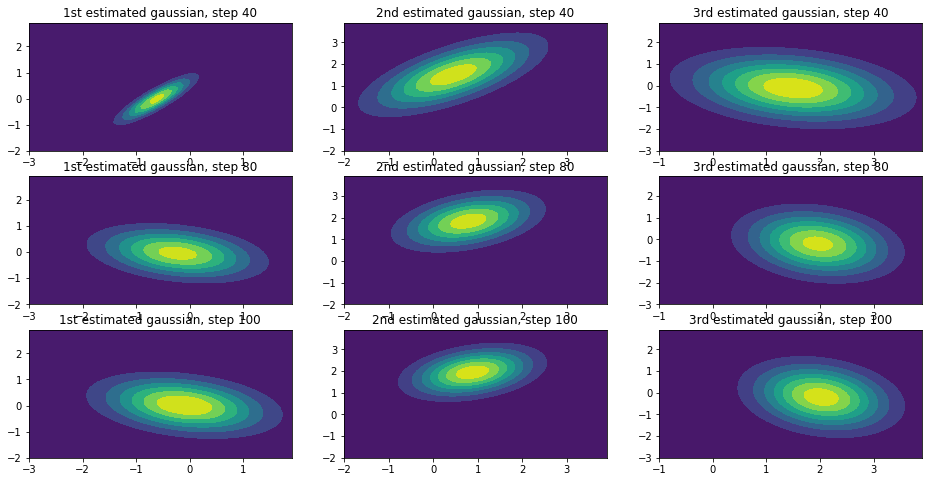

In [68]:
from scipy.stats import multivariate_normal


x, y = np.mgrid[-3:2:.1, -2:3:.1]
x1, y1 = np.mgrid[-2:4:.1, -2:4:.1]
x2, y2 = np.mgrid[-1:4:.1, -3:3:.1]

# step 40
step = 19
rv, pos  = multivariate(mu[step], sigma[step], pi[step], 0, x, y)
rv1, pos1  = multivariate(mu[step], sigma[step], pi[step], 1, x1, y1)
rv2, pos2  = multivariate(mu[step], sigma[step], pi[step], 2, x2, y2)

# step 80
step = 79
rv3, pos3  = multivariate(mu[step], sigma[step], pi[step], 0, x, y)
rv4, pos4  = multivariate(mu[step], sigma[step], pi[step], 1, x1, y1)
rv5, pos5  = multivariate(mu[step], sigma[step], pi[step], 2, x2, y2)

# step 100
step = 99
rv6, pos6  = multivariate(mu[step], sigma[step], pi[step], 0, x, y)
rv7, pos7  = multivariate(mu[step], sigma[step], pi[step], 1, x1, y1)
rv8, pos8  = multivariate(mu[step], sigma[step], pi[step], 2, x2, y2)


plt.subplot(3, 3, 1)
plt.contourf(x, y, rv.pdf(pos))
plt.title('1st estimated gaussian, step 40')
plt.subplot(3, 3, 2)
plt.contourf(x1, y1, rv1.pdf(pos1))
plt.title('2nd estimated gaussian, step 40')
plt.subplot(3, 3, 3)
plt.contourf(x2, y2, rv2.pdf(pos2))
plt.title('3rd estimated gaussian, step 40')


plt.subplot(3, 3, 4)
plt.contourf(x, y, rv3.pdf(pos3))
plt.title('1st estimated gaussian, step 80')
plt.subplot(3, 3, 5)
plt.contourf(x1, y1, rv4.pdf(pos4))
plt.title('2nd estimated gaussian, step 80')

plt.subplot(3, 3, 6)
plt.contourf(x2, y2, rv5.pdf(pos5))
plt.title('3rd estimated gaussian, step 80')


plt.subplot(3, 3, 7)
plt.contourf(x, y, rv6.pdf(pos6))
plt.title('1st estimated gaussian, step 100')
plt.subplot(3, 3, 8)
plt.contourf(x1, y1, rv7.pdf(pos7))
plt.title('2nd estimated gaussian, step 100')
plt.subplot(3, 3, 9)
plt.contourf(x2, y2, rv8.pdf(pos8))
plt.title('3rd estimated gaussian, step 100')

##### <font color='color'> Final estimated gaussians VS real gaussians contours </font>


Text(0.5,1,'3rd real gaussian')

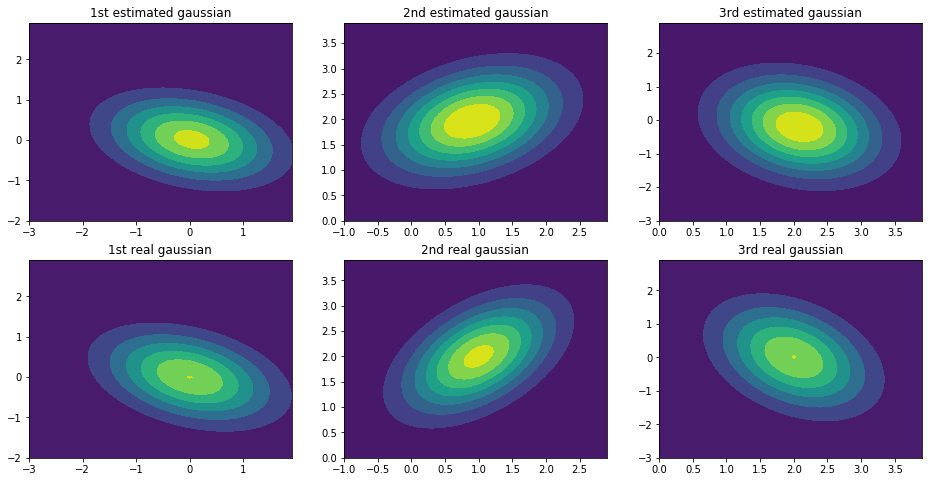

In [63]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-3:2:.1, -2:3:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(estimated_mean[0], estimated_cov[0])
rv1 = multivariate_normal(mu1, sigma1)

x1, y1 = np.mgrid[-1:3:.1, 0:4:.1]
pos1 = np.empty(x1.shape + (2,))
pos1[:, :, 0] = x1; pos1[:, :, 1] = y1
rv2 = multivariate_normal(estimated_mean[1], estimated_cov[1])
rv3 = multivariate_normal(mu2, sigma2)

x2, y2 = np.mgrid[0:4:.1, -3:3:.1]
pos2 = np.empty(x2.shape + (2,))
pos2[:, :, 0] = x2; pos2[:, :, 1] = y2
rv4 = multivariate_normal(estimated_mean[2], estimated_cov[2])
rv5 = multivariate_normal(mu3, sigma3)

plt.subplot(2, 3, 1)
plt.contourf(x, y, rv.pdf(pos))
#plt.plot(xn[:,0], xn[:,1], 'b.')
plt.title('1st estimated gaussian')
plt.subplot(2, 3, 4)
plt.contourf(x, y, rv1.pdf(pos))
plt.title('1st real gaussian')


plt.subplot(2, 3, 2)
plt.contourf(x1, y1, rv2.pdf(pos1))
plt.title('2nd estimated gaussian')
plt.subplot(2, 3, 5)
plt.contourf(x1, y1, rv3.pdf(pos1))
plt.title('2nd real gaussian')

plt.subplot(2, 3, 3)
plt.contourf(x2, y2, rv4.pdf(pos2))
plt.title('3rd estimated gaussian')
plt.subplot(2, 3, 6)
plt.contourf(x2, y2, rv5.pdf(pos2))
plt.title('3rd real gaussian')


#### <font color='color'> Question 3.2.b : Log Likelihood vs Iterations </font>


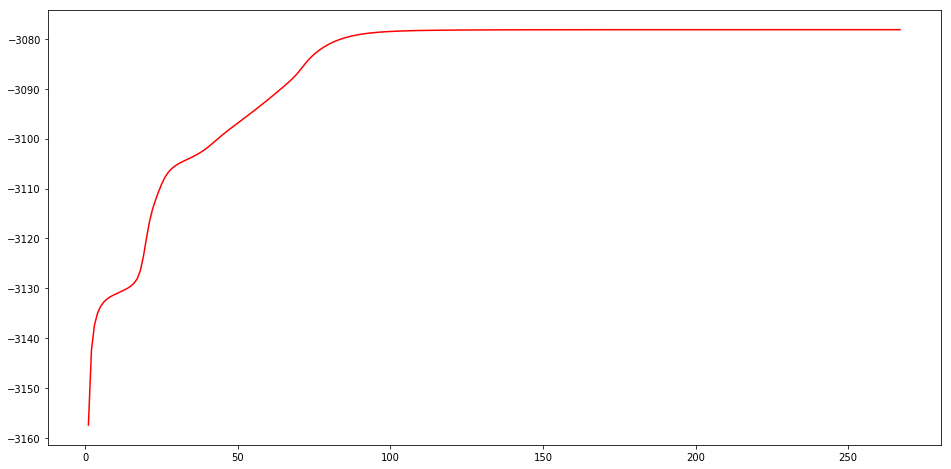

In [64]:
plt.plot(np.arange(1, len(pi) - 1), log_likelihood[1:], 'r',   label='log_likelihood')

#### We can see that the log likelihood is an increasing function and it remains conctant at the end of the algorithm

#### <font color='color'> Question 3.2.c : How sensitive is the EM algorithm for different initial values? </font>


In order to test the sensitivity of the EM algorithm to the initial values, we are going to run the algorithm for different initializations. 

* multiple random initilizations

* use the results of k-means as an initialization : Take the center of clusters as the mean of our gaussians, and the covariance of each cluster as the covariance of our gaussians and the propotion of points in each cluster as pi
<br>

* start from an initialization near to the real parameters

After that, we are going to save the number of iterations we had in each method (so that we satisfy our stopping condition) and to calculate $ \sum_{k=1}^{K}|| \mu_k^{real} - \mu_k^{estimated} ||^2 + || \Sigma_k^{real} - \Sigma_k^{estimated} ||^2 + || \pi_k^{real} - \pi_k^{estimated} ||^2$

##### <font color='color'> 5 random realizations </font>


In [75]:
# Real parameters
K = 3
N = 1000
pi = [0.3, 0.2, 0.5]
mu1 = [0,0]
mu2 = [1,2]
mu3 = [2,0]
mu = [ mu1, mu2, mu3 ]
sigma1 = [[1, -0.25], [-0.25, 0.5]]
sigma2 = [[0.5, 0.25], [0.25, 0.5]]
sigma3 = [[0.5, -0.25], [-0.25, 1]]

sigma = [sigma1, sigma2, sigma3]

In [76]:
nb_step = []
error = []
for r in range(5):
    pi0 = np.random.uniform(0,1,K)
    pi0 = pi0 / sum(pi0)

    d = xn.shape[1]
    mu0 = []
    for i in range(K):
        mu0.append(np.random.uniform(0,5,d))

    sigma0 = []
    for i in range(K):
        sigma0.append(np.random.uniform(0,5,(d,d)))

    t_max = 500
    (pi_eval, mu_eval, sigma_eval, gamma, log_likelihood) = EM_algorithm(xn, K, pi0, mu0, sigma0, t_max)
    
    #nb_steps
    nb_step.append(len(pi_eval))
    
    #error
    estimated_pi = pi_eval[-1]
    estimated_mean = mu_eval[-1]
    estimated_cov = sigma_eval[-1]
    # to compare the estimated results with the real ones, we need first to rearrange the vectors : 
    indices = np.argsort(estimated_mean, axis = 0)[:,0]
    estimated_mean = estimated_mean[indices]
    estimated_cov = np.array(estimated_cov)[indices]
    estimated_pi = estimated_pi[indices]
    
    norm = 0
    for k in range(K):
        norm += np.linalg.norm( estimated_cov[k] - sigma[k] )**2
        norm += np.linalg.norm(estimated_mean[k] - mu[k])**2

    norm += np.linalg.norm(estimated_pi - pi)**2
    error.append(norm)

In [77]:
d = {'Simulation number': ['random simulation ' + str(i) for i in np.arange(1,6)], 'Number of iterations': nb_step,'error': error}
results = pd.DataFrame(data=d)

In [78]:
results

,Simulation number,Number of iterations,error
0,random simulation 1,233,0.197080
1,random simulation 2,375,0.195727
2,random simulation 3,501,9.086334
3,random simulation 4,180,0.197097
4,random simulation 5,157,0.195732


##### <font color='color'> Using kmeans </font>


In [79]:
# Real parameters
K = 3
N = 1000
pi = [0.3, 0.2, 0.5]
mu1 = [0,0]
mu2 = [1,2]
mu3 = [2,0]
mu = [ mu1, mu2, mu3 ]
sigma1 = [[1, -0.25], [-0.25, 0.5]]
sigma2 = [[0.5, 0.25], [0.25, 0.5]]
sigma3 = [[0.5, -0.25], [-0.25, 1]]

sigma = [sigma1, sigma2, sigma3]

In [80]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=K, random_state=0).fit(xn)

In [81]:
mu0 = list(kmeans.cluster_centers_)

In [82]:
sigma0 = [np.cov(xn[kmeans.labels_ == 0].T), 
                  np.cov(xn[kmeans.labels_ == 1].T),
                  np.cov(xn[kmeans.labels_ == 2].T)]

In [83]:
pi0 = np.array([np.sum(kmeans.labels_ == 0) / N, 
                np.sum(kmeans.labels_ == 1) / N, 
                np.sum(kmeans.labels_ == 2) / N ])

In [89]:
t_max = 500
d = xn.shape[1]
pi_eval, mu_eval, sigma_eval, gamma, log_likelihood = EM_algorithm(xn, K, pi0, mu0, sigma0, t_max)

#nb_steps
nb_step = len(pi_eval)

#error
estimated_pi = pi_eval[-1]
estimated_mean = mu_eval[-1]
estimated_cov = sigma_eval[-1]
# to compare the estimated results with the real ones, we need first to rearrange the vectors : 
indices = np.argsort(estimated_mean, axis = 0)[:,0]
estimated_mean = estimated_mean[indices]
estimated_cov = np.array(estimated_cov)[indices]
estimated_pi = estimated_pi[indices]

norm = 0
for k in range(K):
    norm += np.linalg.norm( estimated_cov[k] - sigma[k] )**2
    norm += np.linalg.norm(estimated_mean[k] - mu[k])**2

norm += np.linalg.norm(estimated_pi - pi)**2
error = norm

In [91]:
results.loc[len(results)] = ['with Kmeans', len(pi_eval), error]

In [92]:
results

,Simulation number,Number of iterations,error
0,random simulation 1,233,0.197080
1,random simulation 2,375,0.195727
2,random simulation 3,501,9.086334
3,random simulation 4,180,0.197097
4,random simulation 5,157,0.195732
5,with Kmeans,135,0.195739


##### <font color='color'> strat from an initialization near to the real parameters </font>


In [93]:
pi0 = np.array([0.27,0.19,0.54])
d = xn.shape[1]
mu0 = [[0.1, 0.05], [1.05, 2.1], [2.01, 0.01]]

sigma0 = [[[1, -0.24], [-0.24, 0.51]],
 [[0.51, 0.26], [0.251, 0.51]],
 [[0.51, -0.26], [-0.252, 1.01]]]

t_max = 500
pi_eval, mu_eval, sigma_eval, gamma, log_likelihood = EM_algorithm(xn, K, pi0, mu0, sigma0, t_max)

In [94]:
nb_step = len(pi_eval)

#error
estimated_pi = pi_eval[-1]
estimated_mean = mu_eval[-1]
estimated_cov = sigma_eval[-1]
# to compare the estimated results with the real ones, we need first to rearrange the vectors : 
indices = np.argsort(estimated_mean, axis = 0)[:,0]
estimated_mean = estimated_mean[indices]
estimated_cov = np.array(estimated_cov)[indices]
estimated_pi = estimated_pi[indices]

norm = 0
for k in range(K):
    norm += np.linalg.norm( estimated_cov[k] - sigma[k] )**2
    norm += np.linalg.norm(estimated_mean[k] - mu[k])**2

norm += np.linalg.norm(estimated_pi - pi)**2
error = norm

In [95]:
results.loc[len(results)] = ['near initialization', len(pi_eval), error]

In [96]:
results

,Simulation number,Number of iterations,error
0,random simulation 1,233,0.197080
1,random simulation 2,375,0.195727
2,random simulation 3,501,9.086334
3,random simulation 4,180,0.197097
4,random simulation 5,157,0.195732
5,with Kmeans,135,0.195739
6,near initialization,125,0.195715


##### <font color='color'> Interpretation </font>


We can see that EM algorithm is very sensitive to the initialization in term of iterations number. In this simulations we saw that we had : 

| Simulation | Number of iterations | error |
| --- | --- | --- |
| random simulation 1 | 233 | 0.197080 |
| random simulation 2 | 375 | 0.195727 |
| random simulation 3 | 501 | 9.086334 |
| random simulation 4 | 180 | 0.197097 |
| random simulation 5 | 157 | 0.195732 |
| Kmeans initialization | 135 | 0.195739 |
| near  initialization| 125 | 0.195715 |

* We can see here that simulations takes from 125 iterations to the fixed maximum 501 iterations. We can see that the 3rd random simulation took 501 iterations and did not convergence. This is due to a bad randomly-generated initialization. 


* In term of infered parameters, all the simulations (except of the 3rd one) gave nearly the same result.


* Using Kmeans to initialize the parameters is known as a good solution. Here we can see a small effect on the iterations number.